# Multi-class vs multi-label classification

In the Applied Machine Learning course, we use the following classification setting, where we have a feature set (X) and a target/class variable (y). Based on the values of y, this classification setting can be divided into two groups: binary classification problem and multi-class classification problem.

<center>
<tr>
<td> <img src="../images/mcc.png" width="300" height="200"> </td>
</tr>
</center>
<b>Fig. A multi-class setting. Here the number of target variable is one, and the number of classes within this variable is more than two.</b>

Some classification models can handle both types of problems, and they are inherently multi-class. Examples include decision trees, naive Bayes, etc. On the other hand, some models only deal with binary classification problems. E.g., support vector machine. It is possible to convert a purely binary classifier into a multi-class classifier using the following strategies: 

## One-vs-Rest or One-vs-All Classifier

Given m classes, we train m binary clas- sifiers, one for each class. Classifier j is trained using tuples of class j as the positive class, and the remaining tuples as the negative class. It learns to return a positive value for class j and a negative value for the rest. To classify an unknown tuple, X, the set of classifiers vote as an ensemble. For example, if classifier j predicts the positive class for X, then class j gets one vote. If it predicts the negative class for X, then each of the classes except j gets one vote. The class with the most votes is assigned to X.

## One-vs-One or All-vs-All Classifier

Given m classes, this approach learns a classifier for each pair of classes. So $\frac{m(m-1)}{2}$ such classifiers are trained.  A classifier is trained using tuples of the two classes it should discriminate. To classify an unknown tuple, each classifier votes. The tuple is assigned the class with the maximum number of votes. All-versus-all tends to be superior to one-versus-all.


## Outputcode Classifier

This classifier converts each class to a binary code, where each postion in the code is called bit. We train one classifier for each bit position. Therefore, in our example we train seven classifiers. If a classifier makes an error, there is a better chance that we may still be able to predict the right class for a given unknown tuple because of the redundancy gained by having additional bits. 


To see related examples, check [[here](https://scikit-learn.org/stable/modules/multiclass.html)]

The opposite of multi-class classification is **multi-label classification**, where there are more than one target variables (binary or multi-class). The key idea is to learn a model that can predict each of these target variables. 

<center>
<tr>
<td> <img src="../images/mlc.png" width="300" height="200"> </td>
</tr>
</center>
<b>Fig. A multi-label classfication setting. Here the number of target variables is $> 1$, and the number of classes within each variable is one or more.</b>

**In this notebook, we will explore a multi-label classification problem with restaurant reviews.** More specifically, we will extract the aspect of restaurant reviews from tweets. In this context, the author of the text may mention none or all aspects of a preset list; in our case, this list is formed by five aspects: service, food, anecdotes, price, and ambiance.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
import seaborn as sns

## Load data


In [2]:
aspects_df = pd.read_csv('/dsa/data/DSA-8410/semeval2014.csv')
aspects_df.head()

,text,service,food,anecdotes/miscellaneous,price,ambience
0,but the staff was so horrible to us,1,0,0,0,0
1,to be completely fair the only redeeming facto...,0,1,1,0,0
2,the food is uniformly exceptional with a very ...,0,1,0,0,0
3,where gabriela personaly greets you and recomm...,1,0,0,0,0
4,for those that go once and dont enjoy it all i...,0,0,1,0,0


# Data stats
Checking the number of tweets per aspects.

In [3]:
df_tmp = aspects_df.drop(['text'], axis=1)
counts = []
categories = list(df_tmp.columns.values)
for i in categories:
    counts.append((i, df_tmp[i].sum()))
df_stats = pd.DataFrame(counts, columns=['aspects', 'number_of_tweets'])
df_stats

,aspects,number_of_tweets
0,service,597
1,food,1233
2,anecdotes/miscellaneous,1131
3,price,319
4,ambience,432




It shows that majority of the tweets are based on food.

Text(0.5, 0, 'category')

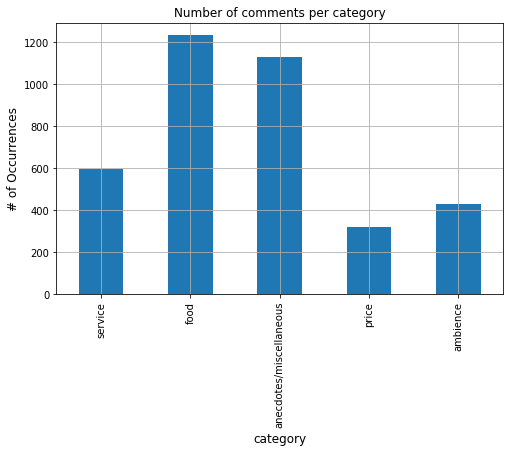

In [4]:
df_stats.plot(x='aspects', y='number_of_tweets', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

# Count tweets having multiple aspects

Let's count the number of tweets based on aspect count. The majority of the tweets have an aspect. Around 500 of the tweets have more than one aspect.

In [5]:
rowsums = aspects_df.iloc[:,1:].sum(axis=1)
x=rowsums.value_counts()
x 

1    2470
2     486
3      82
4       6
dtype: int64

# Extracting Features from text

Here the given input is a tweet, and we need to extract features from this text. The aspects of the tweets are multiple target variables. Hence this problem falls under multi-label classification problem. 


In [6]:
X = aspects_df["text"]
y = np.asarray(aspects_df[aspects_df.columns[1:]])

# Fit tfidf vectorizer

As it is difficult for an ML model to learn from a string directly, we will transform each tweet into a feature vector of numbers. This task can be done by `TfidfVectorizer`.  TF stands for **term frequency** and IDF denotes **inverse document frequency**. We will revisit this concept in detail while discussing information retrieval concepts. For the time being, we assume that we know a mechanism to convert a text string to a numeric vector representation where each vector element is a term or word. 

In [7]:
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.85)  # max vocabulary size is 1000
vectorizer.fit(X)

TfidfVectorizer(max_df=0.85, max_features=1000)

# Split train test

We split the data into 80/20%. 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Convert text to a feature vector

The vectorizer converts each tweet to numeric feature vector.

In [9]:
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Build a multi-label (aka multioutput) classifier

As we need to predict multiple classes for each feature vector, we will be using a simpler version of multi-label classifier, which is `MultiOutputClassifier`. This meta classifier creates a classifier for a category and then combines the output of these classifiers to provide the final prediction. We can pass any classifier to this meta classifier. In this example, we will use a decision tree classifier. 

In [10]:
clf = MultiOutputClassifier(DecisionTreeClassifier())

# Train and predict

Train the model and predict the output of the test set. 

In [11]:
clf.fit(X_train_tfidf, y_train)
val_preds = clf.predict(X_test_tfidf)

In [12]:
val_preds

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [1, 1, 0, 0, 1],
       [1, 1, 1, 0, 0],
       [0, 0, 1, 0, 1]])

# Estimating accuracy

Here the total number of target values is num_rows x num_targets. We need to estimate accuracy from the proportion of match between the true target matrix and the predicted target matrix. 

In [13]:
acc = np.sum(val_preds==y_test) / (y_test.shape[0]*y_test.shape[1])
print(f"Acc: {acc:.2}")

Acc: 0.84


# Qualitative evaluation

Let's manually inspect the true and predicted aspects for some of the tweets. 

In [14]:
# find sample in test having 3 or more aspects

pos = np.where(np.sum(y_test, 1) == 3)[0]

# check only 10 sample
pos = pos[:10]

aspects = aspects_df.columns[1:]

for _idx in pos:
    
    print("Review: ", X_test.iloc[_idx])
    tcol = np.where(y_test[_idx] == 1)[0]
    print("Actual aspect: ", [aspects[i] for i in tcol])
    tcol = np.where(val_preds[_idx] == 1)[0]
    print("Predicted aspect: ", [aspects[i] for i in tcol])
    print("=" * 80)
    print()

Review:  delicious food at a great price but do not go here on a cold day and sit by the front door
Actual aspect:  ['food', 'price', 'ambience']
Predicted aspect:  ['food', 'price']

Review:  super friendly and knowledgable staff fabulous bistro fare and a wonderful jazz brunch with great live jazz the chilaquiles were awesome
Actual aspect:  ['service', 'food', 'ambience']
Predicted aspect:  ['service', 'ambience']

Review:  with so many good restaurants on the uws i dont need overpriced food absurdly arrogant waitstaff who dont recognize they work at a glorified diner clumsy service and management that doesnt care
Actual aspect:  ['service', 'food', 'price']
Predicted aspect:  ['service', 'food', 'price']

Review:  nha trang while being notorious for utter lack of comfort and decor horribly slow wait staff and horribly quick meals is one of the best vietnamese restaurants ive ever been to the pho is delicious and comes with very fresh vegtables
Actual aspect:  ['service', 'food', 'a

# Save your notebook, then `File > Close and Halt`